#### 1. Import packages

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import shap
from plotnine import *
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
df = pd.read_csv('df_clean.csv')

#### 2. Feature Engineering

In [6]:
print(df['SEX'].value_counts())
print(df['MARRIAGE'].value_counts())

SEX
2    18091
1    11874
Name: count, dtype: int64
MARRIAGE
2    15945
1    13643
3      377
Name: count, dtype: int64


In [7]:
df['SEX_MAR'] = 0
df.loc[((df['SEX'] == 1) & (df['MARRIAGE'] == 1)), 'SEX_MAR'] = 1 #'Married Man'
df.loc[((df['SEX'] == 1) & (df['MARRIAGE'] == 2)), 'SEX_MAR'] = 2 #'Single Man'
df.loc[((df['SEX'] == 1) & (df['MARRIAGE'] == 3)), 'SEX_MAR'] = 3 #'Other Man'
df.loc[((df['SEX'] == 2) & (df['MARRIAGE'] == 1)), 'SEX_MAR'] = 4 #'Married Woman'
df.loc[((df['SEX'] == 2) & (df['MARRIAGE'] == 2)), 'SEX_MAR'] = 5 #'Single Woman'
df.loc[((df['SEX'] == 2) & (df['MARRIAGE'] == 3)), 'SEX_MAR'] = 6 #'Other Woman'



In [8]:
sex_mar_y_counts = pd.crosstab(df['SEX_MAR'], df['Y'], rownames=['SEX_MAR'], colnames=['Y'], margins=True)
sex_mar_y_counts['% Default'] = (sex_mar_y_counts[1]/sex_mar_y_counts['All']) * 100
sex_mar_y_counts

Y,0,1,All,% Default
SEX_MAR,,,,
1,3841,1343,5184,25.906636
2,5061,1484,6545,22.673797
3,103,42,145,28.965517
4,6601,1858,8459,21.964771
5,7544,1856,9400,19.744681
6,185,47,232,20.258621
All,23335,6630,29965,22.125813


Married men have higher default % than married women. Each marriage status, men have higher default % as well.

In [9]:
for i in range(1, 7):
    ratio = df[f'PAY_RATIO_{i}'] = (df[f'PAY_AMT{i}'] / df[f'BILL_AMT{i}'])
    ratio.replace([np.inf, -np.inf], np.nan, inplace = True)
    df[f'PAY_RATIO_{i}'] = ratio.fillna(0)

In [10]:
for i in range(1, 7):
    util = df[f'CREDIT_UTILIZATION_{i}'] = (df[f'BILL_AMT{i}'] / df[f'LIMIT_BAL'])
    util.replace([np.inf, -np.inf], np.nan, inplace = True)
    df[f'CREDIT_UTILIZATION_{i}'] = ratio.fillna(0)


I want to see how much customers spend on average in proportion to their credit limit.

new balance = previous balance - payment + new charges <br>
new charges = previous balance - payment - new balance <br>
            = payment - previous balance + new balance <br>
            = payment - (previous balance - new balance) <br>

In [11]:
df['AVG_EXP_5'] = (df['PAY_5'] - (df['BILL_AMT5'] - df['BILL_AMT6']))/df['LIMIT_BAL'] # Spending in May

df['AVG_EXP_4'] = (((df['PAY_4'] - (df['BILL_AMT4'] - df['BILL_AMT5'])) 
                + (df['PAY_5'] - (df['BILL_AMT5'] - df['BILL_AMT6']))) / 2 )/df['LIMIT_BAL'] # Spending in June

df['AVG_EXP_3'] = (((df['PAY_3'] - (df['BILL_AMT3'] - df['BILL_AMT4'])) 
                + (df['PAY_4'] - (df['BILL_AMT4'] - df['BILL_AMT5'])) 
                + (df['PAY_5'] - (df['BILL_AMT5'] - df['BILL_AMT6'])))/3)/df['LIMIT_BAL'] # Spending in July

df['AVG_EXP_2'] = (((df['PAY_2'] - (df['BILL_AMT2'] - df['BILL_AMT3'])) 
                + (df['PAY_3'] - (df['BILL_AMT3'] - df['BILL_AMT4'])) 
                + (df['PAY_4'] - (df['BILL_AMT4'] - df['BILL_AMT5'])) 
                + (df['PAY_5'] - (df['BILL_AMT5'] - df['BILL_AMT6'])))/4)/df['LIMIT_BAL'] # Spending in August

df['AVG_EXP_1'] = (((df['PAY_1'] - (df['BILL_AMT1'] - df['BILL_AMT2']))
                + (df['PAY_2'] - (df['BILL_AMT2'] - df['BILL_AMT3'])) 
                + (df['PAY_3'] - (df['BILL_AMT3'] - df['BILL_AMT4'])) 
                + (df['PAY_4'] - (df['BILL_AMT4'] - df['BILL_AMT5'])) 
                + (df['PAY_5'] - (df['BILL_AMT5'] - df['BILL_AMT6'])))/5)/df['LIMIT_BAL'] # Spending in September

In [12]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,CREDIT_UTILIZATION_2,CREDIT_UTILIZATION_3,CREDIT_UTILIZATION_4,CREDIT_UTILIZATION_5,CREDIT_UTILIZATION_6,AVG_EXP_5,AVG_EXP_4,AVG_EXP_3,AVG_EXP_2,AVG_EXP_1
count,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,...,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000
mean,167442.005006,1.603738,1.842750,1.557283,35.487969,0.356416,0.320340,0.304288,0.258935,0.221625,...,-0.601042,-0.601042,-0.601042,-0.601042,-0.601042,-0.014535,-0.020477,-0.024558,-0.023157,-0.021055
std,129760.135222,0.489128,0.744513,0.521431,9.219459,0.760752,0.802064,0.790696,0.761200,0.717768,...,80.629341,80.629341,80.629341,80.629341,80.629341,0.141948,0.099833,0.083920,0.069900,0.060307
min,10000.000000,1.000000,1.000000,1.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-11349.571429,-11349.571429,-11349.571429,-11349.571429,-11349.571429,-4.928000,-2.319000,-3.043933,-1.364050,-1.061900
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.015100,-0.020391,-0.030473,-0.035388,-0.036360
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.039551,0.039551,0.039551,0.039551,0.039551,0.000000,0.000000,-0.000537,-0.000953,-0.001384
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.146817,0.146817,0.146817,0.146817,0.146817,0.011725,0.008250,0.006362,0.006018,0.005850
max,1000000.000000,2.000000,4.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,2643.330000,2643.330000,2643.330000,2643.330000,2643.330000,2.008971,1.136875,0.634667,0.456825,0.365460


New variables, SEX_MAR,PAY_RATIO_i, CREDIT_UTILIZATION_i, AVG_EXP_i are created.

#### 3. Feature Importance - Random Forest Classifier

##### a)Set target variable

In [13]:
y = df['Y'].copy()
X = df.drop('Y', axis =1 ).copy()

##### b)Data split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 100, shuffle=True)

##### c)Random Forest Classifier for Feature Importance

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)


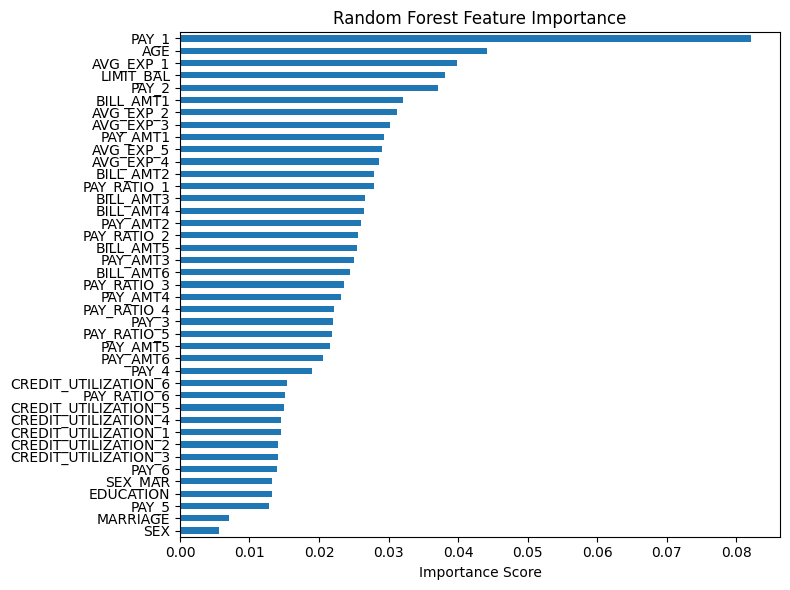

PAY_1                   0.082196
AGE                     0.044233
AVG_EXP_1               0.039789
LIMIT_BAL               0.038153
PAY_2                   0.037109
BILL_AMT1               0.032069
AVG_EXP_2               0.031191
AVG_EXP_3               0.030261
PAY_AMT1                0.029286
AVG_EXP_5               0.028997
AVG_EXP_4               0.028682
BILL_AMT2               0.027913
PAY_RATIO_1             0.027901
BILL_AMT3               0.026670
BILL_AMT4               0.026400
PAY_AMT2                0.026013
PAY_RATIO_2             0.025565
BILL_AMT5               0.025459
PAY_AMT3                0.025064
BILL_AMT6               0.024462
PAY_RATIO_3             0.023624
PAY_AMT4                0.023163
PAY_RATIO_4             0.022126
PAY_3                   0.022026
PAY_RATIO_5             0.021849
PAY_AMT5                0.021629
PAY_AMT6                0.020620
PAY_4                   0.018970
CREDIT_UTILIZATION_6    0.015332
PAY_RATIO_6             0.015125
CREDIT_UTI

In [16]:
plt.figure(figsize=(8, 6))
importances.plot(kind='barh')
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

print(importances.sort_values(ascending=False))

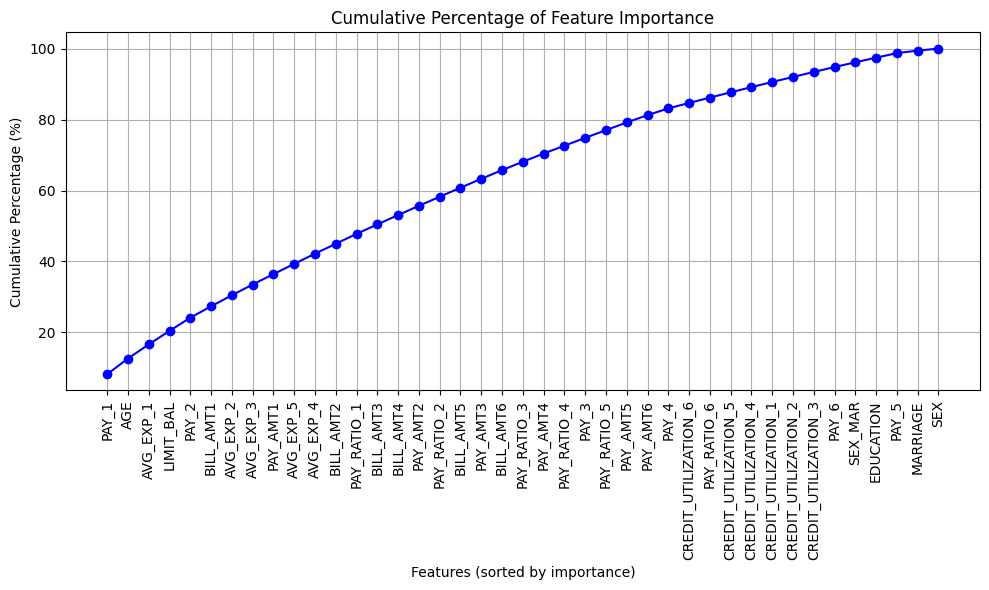

In [17]:
# Calculate cumulative percentage
importances_sorted = importances.sort_values(ascending=False)
cumulative_importance = importances_sorted.cumsum() / importances_sorted.sum() * 100

# Plot cumulative percentage
plt.figure(figsize=(10, 6))
plt.plot(cumulative_importance, marker='o', linestyle='-', color='b')
plt.title('Cumulative Percentage of Feature Importance')
plt.xlabel('Features (sorted by importance)')
plt.ylabel('Cumulative Percentage (%)')
plt.xticks(ticks=range(len(importances_sorted)), labels=importances_sorted.index, rotation=90)
plt.grid()
plt.tight_layout()
plt.show()

In [18]:
pay_ratio_columns = [f'PAY_RATIO_{i}' for i in range(1, 7)]
pay_amt_columns = [f'PAY_AMT{i}' for i in range(1, 7)]

correlation_matrix = df[pay_ratio_columns + pay_amt_columns].corr()

# Extract correlations between PAY_RATIO and PAY_AMT columns
correlation = correlation_matrix.loc[pay_ratio_columns, pay_amt_columns]
print(correlation)

             PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6
PAY_RATIO_1 -0.006287 -0.009689 -0.004857 -0.004075 -0.000855 -0.024695
PAY_RATIO_2  0.007847 -0.074907  0.004680  0.003244 -0.005459  0.000530
PAY_RATIO_3  0.002625  0.003040 -0.042917  0.002302  0.000484  0.001732
PAY_RATIO_4  0.004682  0.002444  0.005213  0.013364  0.001178  0.003723
PAY_RATIO_5  0.001881  0.008601  0.003438  0.004777  0.001610  0.006370
PAY_RATIO_6  0.003928  0.009775 -0.011822 -0.008748  0.004693  0.017924


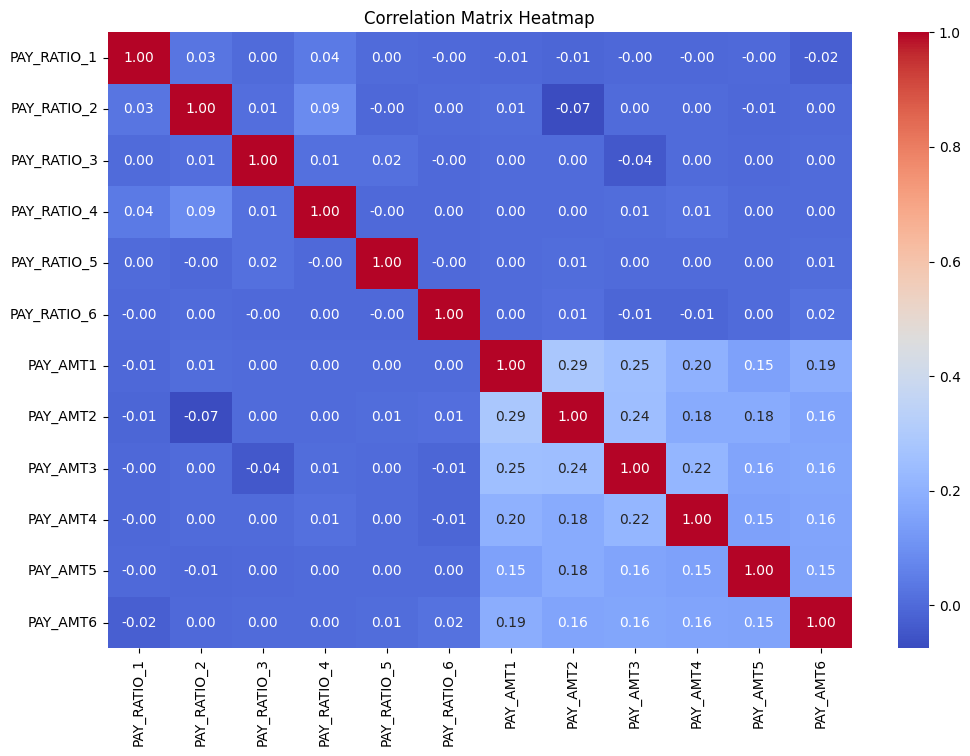

In [19]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

Dropping columns: SEX, MARRIAGE, CREDIT_UTILIZATION

In [20]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Y',
       'SEX_MAR', 'PAY_RATIO_1', 'PAY_RATIO_2', 'PAY_RATIO_3', 'PAY_RATIO_4',
       'PAY_RATIO_5', 'PAY_RATIO_6', 'CREDIT_UTILIZATION_1',
       'CREDIT_UTILIZATION_2', 'CREDIT_UTILIZATION_3', 'CREDIT_UTILIZATION_4',
       'CREDIT_UTILIZATION_5', 'CREDIT_UTILIZATION_6', 'AVG_EXP_5',
       'AVG_EXP_4', 'AVG_EXP_3', 'AVG_EXP_2', 'AVG_EXP_1'],
      dtype='object')

In [21]:
df.shape

(29965, 42)

##### d)Feature Selection

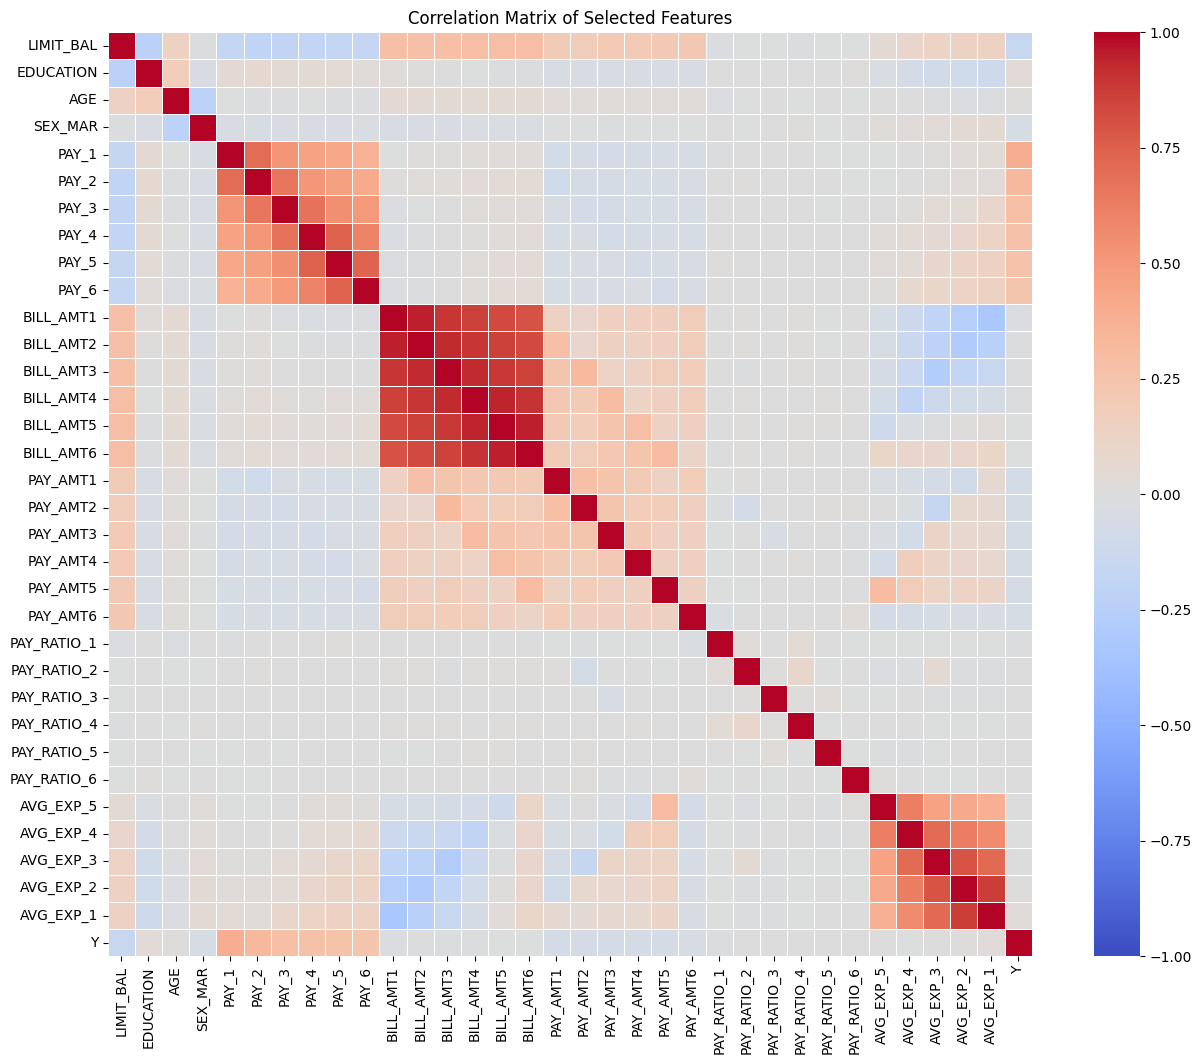

In [22]:
features = [
    'LIMIT_BAL', 'EDUCATION', 'AGE', 'SEX_MAR',
    'PAY_1', 'PAY_2','PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
    'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
    'PAY_RATIO_1', 'PAY_RATIO_2', 'PAY_RATIO_3', 'PAY_RATIO_4', 'PAY_RATIO_5', 'PAY_RATIO_6', 
    'AVG_EXP_5','AVG_EXP_4', 'AVG_EXP_3', 'AVG_EXP_2', 'AVG_EXP_1','Y'
]

selected_df = df[features]

corr_matrix = selected_df.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt='.2f', square=True, linewidths=0.5, vmax=1, vmin=-1)
plt.title("Correlation Matrix of Selected Features")
plt.show()


In [53]:
selected_df.shape

(29965, 34)

In [54]:
y = selected_df['Y'].copy()
X = selected_df.drop('Y', axis =1 ).copy()

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 100, shuffle=True)

In [64]:
X_train.shape

(23972, 33)

In [65]:
X_test.shape

(5993, 33)

#### 4. Data Preprocessing

##### a) Sampling - without sampling technique

In [72]:
df_normal = X_train.join(y_train)
print(df_normal.head())
print(df_normal.shape)

       LIMIT_BAL  EDUCATION  AGE  SEX_MAR  PAY_1  PAY_2  PAY_3  PAY_4  PAY_5  \
7641      150000          1   30        4      1      2      0      0      0   
14609     230000          1   34        4      0      0      0      0      0   
23282     300000          2   42        4      0      0      0      0      0   
21193     250000          2   45        1      0      0      0      0      0   
9336       20000          3   50        5      0      0      0      0      0   

       PAY_6  ...  PAY_RATIO_3  PAY_RATIO_4  PAY_RATIO_5  PAY_RATIO_6  \
7641       2  ...     0.000048     0.193280     0.000000    72.339080   
14609      0  ...     0.586436     0.707653     0.881965     0.521675   
23282      0  ...     0.043708     0.030315     0.041732     0.040423   
21193      0  ...     0.036210     0.019886     0.040308     0.051593   
9336       0  ...     0.054089     0.052140     0.031744     0.015135   

       AVG_EXP_5  AVG_EXP_4  AVG_EXP_3  AVG_EXP_2  AVG_EXP_1  Y  
7641    0.0000

##### b) Sampling - oversampling minority

In [73]:
df_majority = df_normal[df_normal['Y'] == 0]
df_minority = df_normal[df_normal['Y'] == 1]

In [74]:
print(df_majority.shape)
print(df_minority.shape)

(18685, 34)
(5287, 34)


In [75]:
from sklearn.utils import resample

df_minority_oversampled = resample(df_minority, replace = True, n_samples = 18685, random_state = 100)

df_oversampled = pd.concat([df_majority, df_minority_oversampled])

df_oversampled.Y.value_counts()

Y
0    18685
1    18685
Name: count, dtype: int64

##### c) Sampling - undersampling majority

In [76]:
df_majority_undersampled = resample(df_majority, replace = False, n_samples = 5287, random_state= 100)

df_undersampled = pd.concat([df_minority, df_majority_undersampled])

df_undersampled.Y.value_counts()

Y
1    5287
0    5287
Name: count, dtype: int64

##### d) Sampling - SMOTE

In [77]:
from imblearn.over_sampling import SMOTE

In [ ]:
sm = SMOTE(random_state= 100)
X_SMOTE, y_SMOTE = sm.fit_resample(X_train, y_train)

print(len(X_SMOTE))
print(len(y_SMOTE))
print(y_SMOTE.sum())


37370
37370
18685


In [84]:
y_train.value_counts()

Y
0    18685
1     5287
Name: count, dtype: int64

In [82]:
y_SMOTE.value_counts()

Y
0    18685
1    18685
Name: count, dtype: int64

##### e) Scaling

In [85]:
scaler = StandardScaler()

In [86]:
y = df_normal['Y'].copy()
X = df_normal.drop('Y', axis =1 ).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 100, shuffle=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [87]:
y_os = df_oversampled['Y'].copy()
X_os = df_oversampled.drop('Y', axis =1 ).copy()

X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(X_os, y_os, train_size = 0.8, random_state = 100, shuffle=True)

X_train_os_scaled = scaler.fit_transform(X_train_os)
X_test_os_scaled = scaler.fit_transform(X_test_os)

In [88]:
y_us = df_undersampled['Y'].copy()
X_us = df_undersampled.drop('Y', axis =1 ).copy()

X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X_us, y_us, train_size = 0.8, random_state = 100, shuffle=True)

X_train_us_scaled = scaler.fit_transform(X_train_us)
X_test_us_scaled = scaler.fit_transform(X_test_us)

In [89]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_SMOTE, y_SMOTE, train_size = 0.8, random_state = 100, shuffle=True)

X_train_sm_scaled = scaler.fit_transform(X_train_sm)
X_test_sm_scaled = scaler.fit_transform(X_test_sm)

#### 5. Model Building

###  RandomForest Classifier

In [72]:
# set up parameters
rfc_metric = 'gini'
n_estimators = 100
random_state = 100

In [73]:
# initialize the classifier
rfc = RandomForestClassifier(n_estimators= n_estimators,
                            random_state = random_state,
                            criterion = rfc_metric,
                            verbose=False)

In [75]:
# train the model
rfc.fit(X_train_scaled, y_train_smote)

RandomForestClassifier(random_state=100, verbose=False)

In [76]:
print(rfc.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 100, 'verbose': False, 'warm_start': False}


In [77]:
print(f"Number of trees in the forest: {len(rfc.estimators_)}")
tree_depths = [estimator.tree_.max_depth for estimator in rfc.estimators_]
print(f"Max depth of trees: {max(tree_depths)}")
print(f"Min depth of trees: {min(tree_depths)}")
print(f"Average depth of trees: {sum(tree_depths)/len(tree_depths):.2f}")

Number of trees in the forest: 100
Max depth of trees: 57
Min depth of trees: 33
Average depth of trees: 40.97


In [78]:
# predict
rfc_pred = rfc.predict(X_test)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names


/tmp/ipykernel_1550/3209157109.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


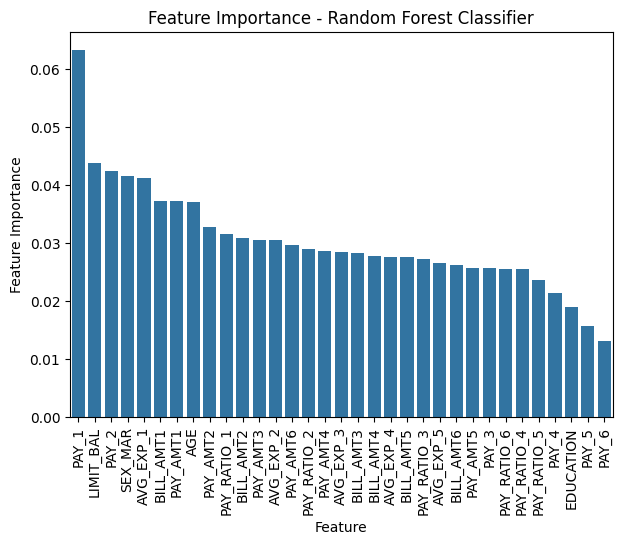

In [79]:
# feature importance
feature_df = pd.DataFrame({'Feature':X.columns, 'Feature Importance':rfc.feature_importances_})
feature_df = feature_df.sort_values(by = 'Feature Importance', ascending = False)
plt.figure(figsize=(7,5))
plt.title("Feature Importance - Random Forest Classifier")
s = sns.barplot(x = 'Feature', y ='Feature Importance', data = feature_df)
s.set_xticklabels(s.get_xticklabels(), rotation=90)
plt.show()

Pay_1, Age, Bill_AMT1, LIMIT_BAL, and BILL_AMT2 are the top 5 in feature importance.

TN: 75.72% , FP: 1.87%, FN: 19.46%, TP: 2.95%


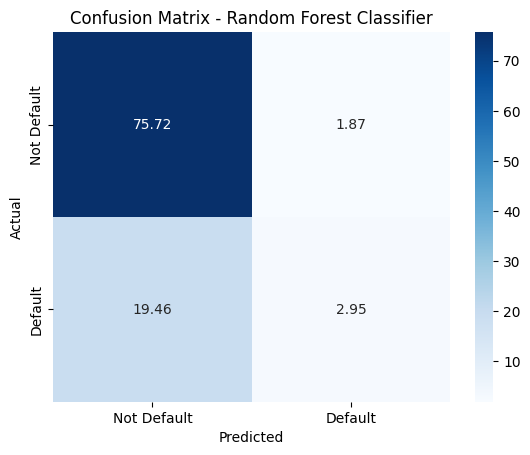

In [80]:
cm = pd.crosstab(y_test, rfc_pred, rownames = ['Actual'], colnames = ['Predicted'])
cm_percent = cm/cm.to_numpy().sum()*100
sns.heatmap(cm_percent,
            xticklabels = ['Not Default', 'Default'],
            yticklabels = ['Not Default', 'Default'],
            annot = True,
            cmap='Blues',
            fmt = '.2f')
plt.title("Confusion Matrix - Random Forest Classifier")

rfc_tn = cm_percent.loc[0,0]
rfc_fp = cm_percent.loc[0,1]
rfc_fn = cm_percent.loc[1,0]
rfc_tp = cm_percent.loc[1,1]

print(f"TN: {rfc_tn:.2f}% , FP: {rfc_fp:.2f}%, FN: {rfc_fn:.2f}%, TP: {rfc_tp:.2f}%")

In [81]:
print(classification_report(y_test, rfc_pred))
print(f"Area Under Curve:", roc_auc_score(y_test, rfc_pred))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      4650
           1       0.61      0.13      0.22      1343

    accuracy                           0.79      5993
   macro avg       0.70      0.55      0.55      5993
weighted avg       0.75      0.79      0.73      5993

Area Under Curve: 0.5538542342212507


In [ ]:
explainer = shap.TreeExplainer(rfc)

shap_values = explainer.shap_values(X_test)

type(shap_values), np.shape(shap_values)

/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


(numpy.ndarray, (5993, 26, 2))

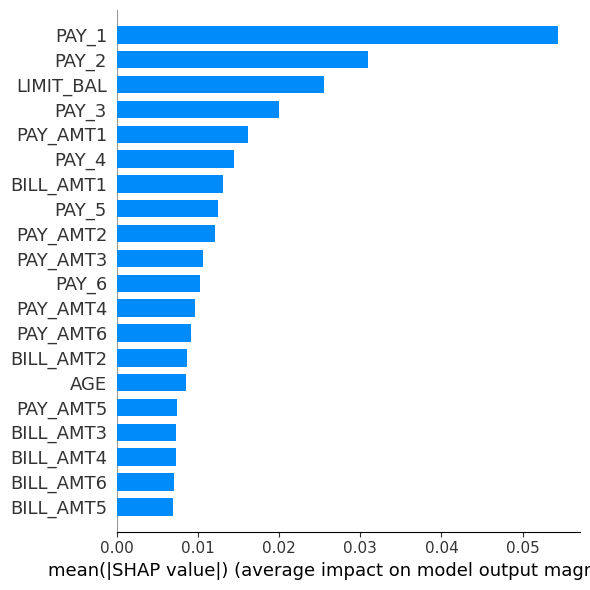

In [ ]:
shap.summary_plot(shap_values[:,:,1], X_test, plot_type="bar", plot_size=(6,6))

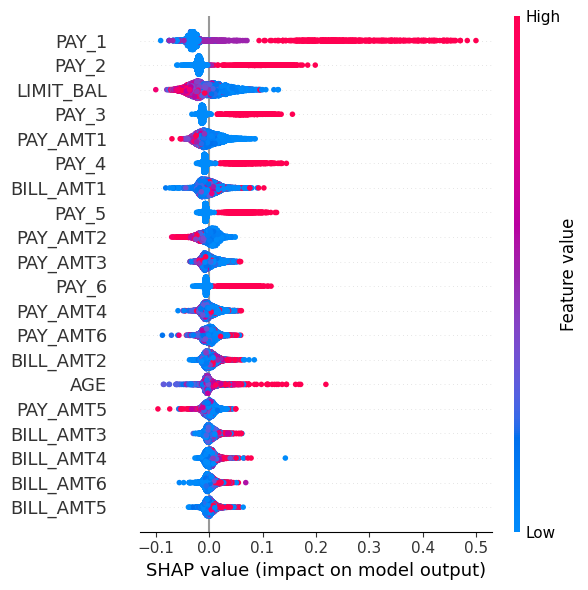

In [ ]:
shap.summary_plot(shap_values[:,:,1], X_test, plot_size=(6,6))

Beeswarm chart indicates the following:
* longer delay in the most recent month (September) likely to increase the possibility of default in the next month - the strongest predictor.
* followed by payment status in August and July.
* lower credit limit balance is more likely to increase the default possibility.
* the amount credit card holder pays in September, the less they pay, the higher default probability is.

Random Forest Classifier achieved AUC of 0.65

###  AdaBoost Classifier

In [8]:
from sklearn.ensemble import AdaBoostClassifier

In [12]:
# set up parameters
learning_rate = 0.1
n_estimators = 100
random_state = 100

In [13]:
# initialize the classifier
abc = AdaBoostClassifier(n_estimators= n_estimators,
                            random_state = random_state,
                            learning_rate=learning_rate)

In [14]:
abc.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.1, n_estimators=100, random_state=100)

In [15]:
abc_pred = abc.predict(X_test)

/tmp/ipykernel_1546/1778916822.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


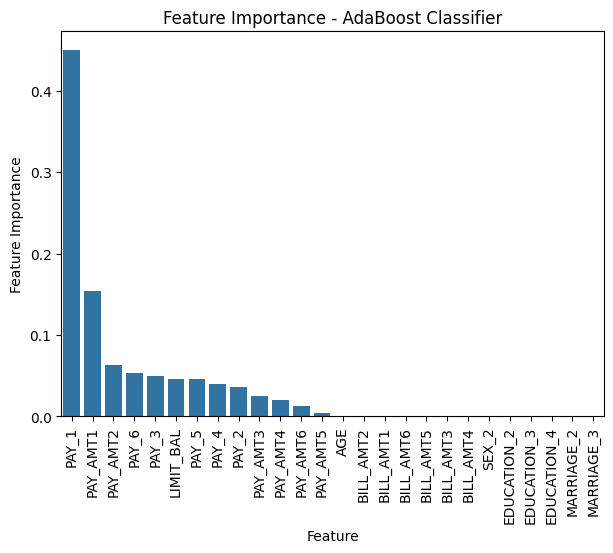

In [16]:
# feature importance
feature_df = pd.DataFrame({'Feature':X.columns, 'Feature Importance':abc.feature_importances_})
feature_df = feature_df.sort_values(by = 'Feature Importance', ascending = False)
plt.figure(figsize=(7,5))
plt.title("Feature Importance - AdaBoost Classifier")
s = sns.barplot(x = 'Feature', y ='Feature Importance', data = feature_df)
s.set_xticklabels(s.get_xticklabels(), rotation=90)
plt.show()

TN: 74.07% , FP: 3.52%, FN: 15.58%, TP: 6.82%


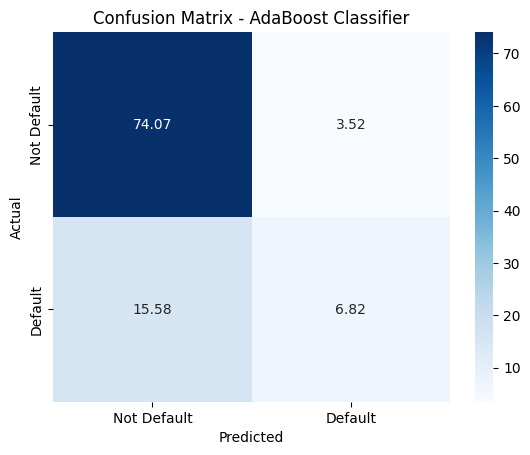

In [48]:
cm = pd.crosstab(y_test, abc_pred, rownames = ['Actual'], colnames = ['Predicted'])
cm_percent = cm/cm.to_numpy().sum() * 100
sns.heatmap(cm_percent,
            xticklabels = ['Not Default', 'Default'],
            yticklabels = ['Not Default', 'Default'],
            annot = True,
            cmap='Blues',
            fmt = '.2f')
plt.title("Confusion Matrix - AdaBoost Classifier")

abc_tn = cm_percent.loc[0,0]
abc_fp = cm_percent.loc[0,1]
abc_fn = cm_percent.loc[1,0]
abc_tp = cm_percent.loc[1,1]

print(f"TN: {abc_tn:.2f}% , FP: {abc_fp:.2f}%, FN: {abc_fn:.2f}%, TP: {abc_tp:.2f}%")

In [20]:
print(classification_report(y_test, abc_pred))
print(f"Area Under Curve:", roc_auc_score(y_test, abc_pred))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      4650
           1       0.66      0.30      0.42      1343

    accuracy                           0.81      5993
   macro avg       0.74      0.63      0.65      5993
weighted avg       0.79      0.81      0.78      5993

Area Under Curve: 0.6295828629532663


#### Train the models: Logistic regression, Support vector machine, and Neural network.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [ ]:
models = {
    LogisticRegression(): "Logistic Regression",
    SVC(): "Support Vector Machine",
    MLPClassifier(): "Neural Network"
}

for model in models.keys():
    model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


#### Evaluate the models: confusion matrix, AUC-ROC, F-1 Score.

In [ ]:
for model, name in models.items():
    print(name + ": {:.2f}%".format(model.score(X_test, y_test)*100))

Logistic Regression: 81.59%
Support Vector Machine: 81.92%
Neural Network: 80.93%


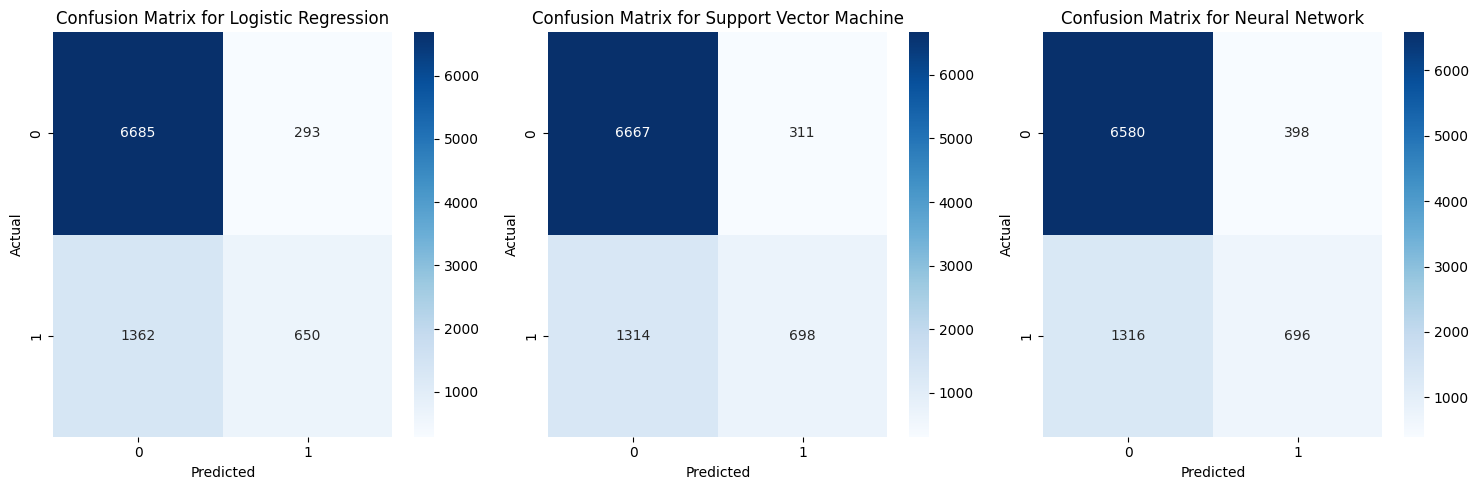

In [ ]:
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (model, name) in zip(axes, models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 8))

for model, name in models.items():
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

NameError: name 'plt' is not defined

Recall: true positive. sensitivity. "Of all actual positives, how many were accurately identified?"

Precision: "Of all predicted positives, how many are actual positives?"

In credit default prediction, false negative is more costly given the nature of the business context. Therefore, measuring high recall is crucial. F-1 score measures both recall and precision, so it could be an efficient metric.

In [ ]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

for model, name in models.items():
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"{name}:")
    print(f"  Recall: {recall:.2f}")
    print(f"  Precision: {precision:.2f}")
    print(f"  Accuracy: {accuracy:.2f}")
    print(f"  F1 Score: {f1:.2f}")
    print()

Logistic Regression:
  Recall: 0.32
  Precision: 0.69
  Accuracy: 0.82
  F1 Score: 0.44

Support Vector Machine:
  Recall: 0.35
  Precision: 0.69
  Accuracy: 0.82
  F1 Score: 0.46

Neural Network:
  Recall: 0.35
  Precision: 0.64
  Accuracy: 0.81
  F1 Score: 0.45

